# Testing 2D L-CNN and baseline models

In [1]:
RECOMPUTE_ALL = True

In [2]:
import sys
import copy
sys.path.append('..')

# pytorch imports
import torch
from lge_cnn.nn.models import LConvBilinNet, BaselineNet
from lge_cnn.nn.data import YMDatasetHDF5
import pytorch_lightning as pl

# other
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import argparse
import pandas
import matplotlib.pyplot as plt

def load_models(models_path, baseline, batch_size=None, cuda=True, override_dataset_paths=None):
    # load model results
    model_results = pickle.load(open(models_path, 'rb'))
    
    models = []
    for r in model_results:
        if not hasattr(r['hparams'], 'num_workers'):
            r['hparams'].num_workers = 0
            
        # override dataset paths if specified
        if override_dataset_paths is not None:
            r['hparams'].train_path = override_dataset_paths['train']
            r['hparams'].val_path = override_dataset_paths['val']
            r['hparams'].test_path = override_dataset_paths['test']

        if baseline:
            m = BaselineNet(r['hparams'])
        else:
            m = LConvBilinNet(r['hparams'])

        if batch_size is not None:
            m.hparams.batch_size = batch_size

        if cuda:
            m.cuda()
        m.load_state_dict(r['state_dict'])
        models.append(m)
        
    return models
    

def test_scatter(models, labels, xlabel="Predicted Value", ylabel="True Value", data='test', title=None):
    for m, l in zip(models, labels):
        # testing
        test_mse = m.mse(global_average=True)
        print("Test MSE ({}): {:.4e}".format(l, test_mse))

        X, Y_pred, Y_true = m.evaluate(data=data)
        Y_pred = np.mean(Y_pred, axis=1)
        Y_true = np.mean(Y_true, axis=1)

        plt.scatter(Y_pred.flatten(), Y_true.flatten(), marker='x', alpha=0.2, label=l)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    
    if title is not None:
        plt.title(title)
        
    x = np.linspace(*plt.gca().get_xlim())
    plt.plot(x, x, c='black', linestyle='dashed')
    
    plt.show()
    
def test_all(dataset_paths, dataset_labels, mode_out, model_result_path, model_label, baseline,
             batch_size=None, cuda=True, override_dataset_paths=None, input_mode=None):
    models = load_models(model_result_path, baseline, batch_size, cuda, override_dataset_paths)
    
    # iterate through test sets
    full_results = []
    for path, label in zip(dataset_paths, dataset_labels):
        # load dataset
        if baseline:
            # different input modes only apply to baselines
            if input_mode is None:
                dataset = YMDatasetHDF5(path, mode_in='uw', mode_out=mode_out, use_idx=False)
            else:
                dataset = YMDatasetHDF5(path, mode_in=input_mode, mode_out=mode_out, use_idx=False)
                
        else:
            dataset = YMDatasetHDF5(path, mode_in='uw', mode_out=mode_out, use_idx=False)
        
        # iterate through models
        for index, m in enumerate(models):
            # update dims and change test set
            m.update_dims(dataset.dims)
            m.test_dataset = dataset
            
            # perform test
            test_mse = m.mse(global_average=True, cuda=cuda, data='test')
            print(index, model_label, label, dataset.dims, test_mse)

            # add to full results
            entry = {
                'dataset': label,
                'dims': dataset.dims,
                'model': model_label,
                'model_index': index,
                'test_mse': test_mse
            }

            full_results.append(entry)
    
    df = pandas.DataFrame(full_results)
    
    return df

def validate_all(model_result_path, model_label, baseline,
                 batch_size=None, cuda=True, override_dataset_paths=None, input_mode=None):
    models = load_models(model_result_path, baseline, batch_size, cuda, override_dataset_paths)
    
    validation_results = []
    for index, m in enumerate(models):
        val_mse = m.mse(global_average=True, cuda=cuda, data='val')
        print(index, model_label, val_mse)
        entry = {
            'model': model_label,
            'model_index': index,
            'val_mse': val_mse
        }
        
        validation_results.append(entry)
    
    df = pandas.DataFrame(validation_results)
    return df

def plot_mse_archs(df, title):
    arch_colors = ["gray", "red", "peru", "olive", "yellow", "green",
                   "darkcyan", "skyblue", "violet", "purple", "black"]
    
    for i, m_label in enumerate(pandas.unique(df['model'])):        
        mses = []
        min_mse = []
        max_mse = []
        mean_mse = []
        median_mse = []
        labels = []
        for ds_label in pandas.unique(df['dataset']):
            sub_df = df[(df['dataset'] == ds_label) & (df['model'] == m_label)]
            mse_array = np.array(sub_df['test_mse'])
            min_mse.append(np.min(mse_array))
            max_mse.append(np.max(mse_array))
            mean_mse.append(np.mean(mse_array))
            median_mse.append(np.median(mse_array))
            labels.append(pandas.unique(sub_df['dataset'])[0])
            mses.append(mse_array)
          
        X = range(len(labels))
        plt.fill_between(X, min_mse, max_mse, alpha=0.25, color=arch_colors[i % len(arch_colors)],
                         label=m_label)
        plt.plot(X, mean_mse, color=arch_colors[i % len(arch_colors)], linestyle='dashed')
        plt.plot(X, median_mse, color=arch_colors[i % len(arch_colors)])  
    
    plt.xticks(X, labels)
    plt.semilogy()
    plt.grid()
    plt.legend()
    
    if title is not None:
        plt.title(title)
        
    plt.show()
        
def save_mse_tables(df, filename_template):
    for i, m_label in enumerate(pandas.unique(df['model'])):        
        mses = []
        min_mse = []
        max_mse = []
        mean_mse = []
        median_mse = []
        labels = []
        for ds_label in pandas.unique(df['dataset']):
            sub_df = df[(df['dataset'] == ds_label) & (df['model'] == m_label)]
            mse_array = np.array(sub_df['test_mse'])
            min_mse.append(np.min(mse_array))
            max_mse.append(np.max(mse_array))
            mean_mse.append(np.mean(mse_array))
            median_mse.append(np.median(mse_array))
            labels.append(pandas.unique(sub_df['dataset'])[0])
            mses.append(mse_array)
            
        data = np.array([list(range(len(min_mse))), min_mse, max_mse, mean_mse, median_mse]).T
        np.savetxt(filename_template.format(m_label), data, delimiter=" ")


def save_scatter_tables(model, filename, data='test'):
    X, Y_pred, Y_true = model.evaluate(data=data)
    Y_pred = np.mean(Y_pred, axis=1).flatten()
    Y_true = np.mean(Y_true, axis=1).flatten()
    array = np.array([Y_pred, Y_true]).T
    np.savetxt(filename, array, delimiter=" ")
    
    
def create_latex_tables(df, dataset_labels_tex, metric_label, add_str):    
    data = []
    for i, m_label in enumerate(pandas.unique(df['model'])):        
        median_mse = []
        for ds_label in pandas.unique(df['dataset']):
            sub_df = df[(df['dataset'] == ds_label) & (df['model'] == m_label)]
            mse_array = np.array(sub_df['test_mse'])
            median_mse.append(np.median(mse_array))
        data.append(median_mse)
    data = np.array(data)
    
    line = metric_label + "{}"
    for i in range(len(data)):
        line += "& {} "
    
    output = ""
    for i, latt_label in enumerate(dataset_labels_tex):
        median_mse = data[:, i]
        min_mse = np.min(median_mse)
        mse_strs = []
        for m in median_mse:
            oom = int(np.floor(np.log10(m)))
            val = m * 10 ** (-oom)
            if min_mse == m:
                m_str = "$\\mathbf{{{:3.2f} \cdot 10^{{ {:d} }}}}$".format(val, oom)
            else:
                m_str = "${:3.2f} \cdot 10^{{ {:d} }}$".format(val, oom)
            mse_strs.append(m_str)
        
        output += line.format(latt_label, *mse_strs) + add_str + " \\\\ \n"
    
    return output

def count_parameters(model_results, baseline, override_dataset_paths=None):
    r = model_results[0]
    
    if override_dataset_paths is not None:
        r['hparams'].train_path = override_dataset_paths['train']
        r['hparams'].val_path = override_dataset_paths['val']
        r['hparams'].test_path = override_dataset_paths['test']
    
    if baseline:
        m = BaselineNet(r['hparams'])
    else:
        m = LConvBilinNet(r['hparams'])
    
    return m.count_trainable_parameters()

def pick_best_model(model_path, model_label, model_baseline, model_results, batch_size, override_dataset_paths=None):
    val_results = validate_all(model_path, model_label, model_baseline, batch_size, cuda=True, override_dataset_paths=override_dataset_paths)
    model_index = val_results.iloc[val_results['val_mse'].idxmin()]['model_index']
    models = load_models(model_path, True, batch_size, True, override_dataset_paths)
    print(models[model_index])
    return best_index, models[best_index]

# Test loop

In [3]:
def compute_test_results(mode_out, model_paths, model_labels, model_baselines,
                         dataset_paths, dataset_labels, dataset_labels_tex,
                         output_path, batch_size=50, override_dataset_paths=None, input_modes=None):
    # compute MSE for every model and every dataset
    print("************")
    print("Test MSEs")
    print("************")
    test_results = []
    if input_modes is None:
        for model_path, model_label, model_baseline in zip(model_paths, model_labels, model_baselines):
            r = test_all(dataset_paths, dataset_labels, mode_out, model_path, model_label, model_baseline, batch_size=batch_size,
                        override_dataset_paths=override_dataset_paths)
            test_results.append(r)
    else:
        for model_path, model_label, model_baseline, input_mode in zip(model_paths, model_labels, model_baselines, input_modes):
            r = test_all(dataset_paths, dataset_labels, mode_out, model_path, model_label, model_baseline, batch_size=batch_size,
                        override_dataset_paths=override_dataset_paths, input_mode=input_mode)
            test_results.append(r)
        
    
    test_results = pandas.concat(test_results)
    
    # save pickled results
    pickle.dump(test_results, open(output_path, "wb"))
    
    return test_results

def compute_val_results(mode_out, model_paths, model_labels, model_baselines,
                        output_path, batch_size=50, override_dataset_paths=None, input_modes=None):
    # compute MSE for every model and every dataset
    print("************")
    print("Validation MSEs")
    print("************")
    val_results = []
    if input_modes is None:
        for model_path, model_label, model_baseline in zip(model_paths, model_labels, model_baselines):
            r = validate_all(model_path, model_label, model_baseline, batch_size,
                             cuda=True, override_dataset_paths=override_dataset_paths)
            val_results.append(r)
    else:
        for model_path, model_label, model_baseline, input_mode in zip(model_paths, model_labels, model_baselines, input_modes):
            r = validate_all(model_path, model_label, model_baseline, batch_size,
                             cuda=True, override_dataset_paths=override_dataset_paths, input_mode=input_mode)
            val_results.append(r)
    
    # save pickled results
    pickle.dump(val_results, open(output_path, "wb"))
    
    return val_results

In [4]:
def run_tests(test_results, val_results, mode_out, model_paths, model_labels, model_baselines,
              dataset_paths, dataset_labels, dataset_labels_tex,
              batch_size=50, override_dataset_paths=None):
    # plot MSEs for all models and datasets
    print("************")
    print("MSE plots")
    print("************")
    plot_mse_archs(test_results, "{}".format(mode_out))
    
    # save all MSE tables
    save_mse_tables(test_results, "{}_plotdata.txt")
        
    # pick best model for each ensemble and create scatter plot data
    print("************")
    print("Best models of each ensemble according to val_loss")
    print("************")
    best_models = []
    for i in range(len(model_paths)):
        model_path = model_paths[i]
        model_label = model_labels[i]
        model_baseline = model_baselines[i]
        val_res = val_results[i]
        
        model_index = val_res.iloc[val_res['val_mse'].idxmin()]['model_index']
        models = load_models(model_path, model_baseline, batch_size, cuda=True,
                             override_dataset_paths=override_dataset_paths)

        best_model = models[model_index]
        save_scatter_tables(best_model, "{}_scatter.txt".format(model_label))
        best_models.append(best_model)
    
    # plot all scatter plots
    print("************")
    print("Scatter plot")
    print("************")
    test_scatter(best_models, model_labels)
    
    # count number of parameters
    print("************")
    print("Trainable parameters")
    print("************")
    for model_path, model_label, model_baseline in zip(model_paths, model_labels, model_baselines):
        model_results = pickle.load(open(model_path, 'rb'))
        num_params = count_parameters(model_results, model_baseline, override_dataset_paths=override_dataset_paths)
        print(model_label, num_params)

# Wilson D2_W1x1

In [5]:
# dataset base path
dataset_path = "../datasets/"

# specific test sets
dataset_paths = [
    dataset_path + "D2_8/test.hdf5",
    dataset_path + "D2_16/test.hdf5",
    dataset_path + "D2_32/test.hdf5",
    dataset_path + "D2_64/test.hdf5"
]

# plot labels for datasets
dataset_labels = [
    "8x8",
    "16x16",
    "32x32",
    "64x64",
]

# dataset labels for tex table
dataset_labels_tex = [
    "$8 \\cdot 8$",
    "$16 \\cdot 16$",
    "$32 \\cdot 32$",
    "$64 \\cdot 64$",
]

# model base path
model_path = "../scripts/"

# model results (lcnns)
model_paths = [
    model_path + "D2_W1x1_lcnn_results.pickle",
]

# add baseline model results
model_path_baseline = "../scripts_baseline/"
base_str = "D2_W1x1_baseline_{}_{}_{}_results.pickle"

archs = ["S1"]
activations = ["relu"]
input_modes = ["uw"]

for a in archs:
    for act in activations:
        for im in input_modes:
            fp = model_path_baseline + base_str.format(a, act, im)
            model_paths.append(fp)

# model labels (used for plot labels and result files)
model_labels = [
    "D2_W1x1_lcnn",
]

# add baseline labels
for a in archs:
    for act in activations:
        for im in input_modes:
            label = "D2_W1x1_baseline_{}_{}_{}".format(a, act, im)
            model_labels.append(label)
        
# whether a model is a baseline or not
model_baselines = [
    False,
]

for a in archs:
    for act in activations:
        for im in input_modes:
            model_baselines.append(True)
            
# what input mode to use (only applies to baselines)
model_input_modes = [
    'uw_legacy'
]

input_modes_dict = {
    "u": "u",
    "uw": "uw",
    "uw_leg": "uw_legacy"
}

for a in archs:
    for act in activations:
        for im in input_modes:
            model_input_modes.append(input_modes_dict[im])

label_map = {
    "D2_W1x1_lcnn": "L-CNN ($W_{1\\times1}$)",
    "D2_W1x1_baseline_S1_relu_uw": "Baseline CNN ($W_{1\\times1}$)"
}

model_labels = [label_map.get(label, label) for label in model_labels]

# output mode
mode_out = "trW_1x1"

# output path for pickled results
output_path = "D2_W1x1_results.pickle"
output_val_path = "D2_W1x1_val_results.pickle"
output_scatter_png = "d2_w1x1_scatter.pdf"

In [6]:
if RECOMPUTE_ALL:
    test_d2_w1x1 = compute_test_results(mode_out, model_paths, model_labels, model_baselines,
                                        dataset_paths, dataset_labels, dataset_labels_tex,
                                        output_path, batch_size=50, input_modes=model_input_modes)

************
Test MSEs
************
0 L-CNN ($W_{1\times1}$) 8x8 [8 8] 7.4729556e-14
1 L-CNN ($W_{1\times1}$) 8x8 [8 8] 4.076739e-16
2 L-CNN ($W_{1\times1}$) 8x8 [8 8] 4.7872815e-16
3 L-CNN ($W_{1\times1}$) 8x8 [8 8] 3.2329694e-16
4 L-CNN ($W_{1\times1}$) 8x8 [8 8] 5.345413e-14
0 L-CNN ($W_{1\times1}$) 16x16 [16 16] 1.9679369e-14
1 L-CNN ($W_{1\times1}$) 16x16 [16 16] 3.0553339e-16
2 L-CNN ($W_{1\times1}$) 16x16 [16 16] 3.4905412e-16
3 L-CNN ($W_{1\times1}$) 16x16 [16 16] 2.7622348e-16
4 L-CNN ($W_{1\times1}$) 16x16 [16 16] 1.4152235e-14
0 L-CNN ($W_{1\times1}$) 32x32 [32 32] 5.412559e-15
1 L-CNN ($W_{1\times1}$) 32x32 [32 32] 2.184919e-16
2 L-CNN ($W_{1\times1}$) 32x32 [32 32] 2.5757173e-16
3 L-CNN ($W_{1\times1}$) 32x32 [32 32] 2.0783375e-16
4 L-CNN ($W_{1\times1}$) 32x32 [32 32] 3.625544e-15
0 L-CNN ($W_{1\times1}$) 64x64 [64 64] 1.9193536e-15
1 L-CNN ($W_{1\times1}$) 64x64 [64 64] 1.7053026e-16
2 L-CNN ($W_{1\times1}$) 64x64 [64 64] 2.016165e-16
3 L-CNN ($W_{1\times1}$) 64x64 [64 6

In [7]:
if RECOMPUTE_ALL:
    val_d2_w1x1 = compute_val_results(mode_out, model_paths, model_labels, model_baselines,
                                      output_val_path, batch_size=50, input_modes=model_input_modes)

************
Validation MSEs
************
0 L-CNN ($W_{1\times1}$) 7.606005e-14
1 L-CNN ($W_{1\times1}$) 3.8458125e-16
2 L-CNN ($W_{1\times1}$) 5.2402524e-16
3 L-CNN ($W_{1\times1}$) 3.6770587e-16
4 L-CNN ($W_{1\times1}$) 5.403322e-14
0 Baseline CNN ($W_{1\times1}$) 2.1436753e-07
1 Baseline CNN ($W_{1\times1}$) 2.6277527e-07
2 Baseline CNN ($W_{1\times1}$) 5.0884756e-07
3 Baseline CNN ($W_{1\times1}$) 0.0014989376
4 Baseline CNN ($W_{1\times1}$) 2.0048808e-06


In [8]:
if not RECOMPUTE_ALL:
    test_d2_w1x1 = pickle.load(open(output_path, "rb"))
    val_d2_w1x1 = pickle.load(open(output_val_path, "rb"))

************
MSE plots
************


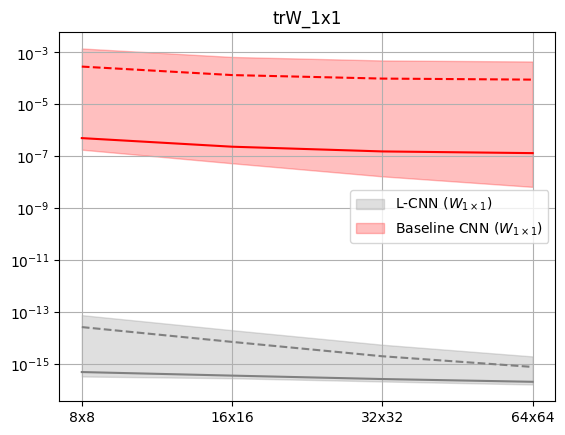

************
Best models of each ensemble according to val_loss
************
************
Scatter plot
************
Test MSE (L-CNN ($W_{1\times1}$)): 3.2330e-16
Test MSE (Baseline CNN ($W_{1\times1}$)): 1.7774e-07


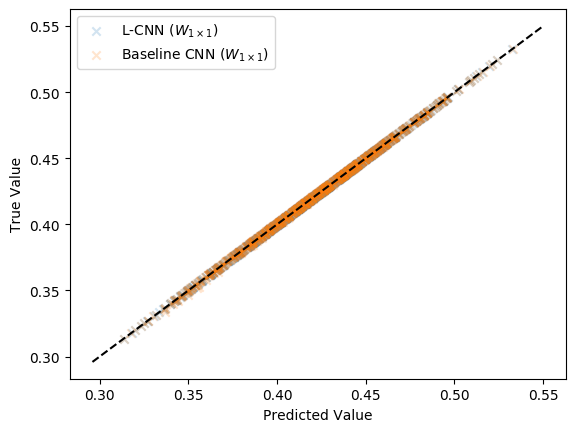

************
Trainable parameters
************
L-CNN ($W_{1\times1}$) 28
Baseline CNN ($W_{1\times1}$) 1237


In [9]:
run_tests(test_d2_w1x1, val_d2_w1x1, mode_out, model_paths, model_labels, model_baselines,
          dataset_paths, dataset_labels, dataset_labels_tex,
          batch_size=50)

# Wilson D2_W1x2

In [10]:
# dataset base path
dataset_path = "../datasets/"

# specific test sets
dataset_paths = [
    dataset_path + "D2_8/test.hdf5",
    dataset_path + "D2_16/test.hdf5",
    dataset_path + "D2_32/test.hdf5",
    dataset_path + "D2_64/test.hdf5"
]

# plot labels for datasets
dataset_labels = [
    "8x8",
    "16x16",
    "32x32",
    "64x64",
]

# dataset labels for tex table
dataset_labels_tex = [
    "$8 \\cdot 8$",
    "$16 \\cdot 16$",
    "$32 \\cdot 32$",
    "$64 \\cdot 64$",
]

# model base path
model_path = "../scripts/"

# model results (lcnns)
model_paths = [
    model_path + "D2_W1x2_lcnn_s_results.pickle",
]

# add baseline model results
model_path_baseline = "../scripts_baseline/"
base_str = "D2_W1x2_baseline_{}_{}_results.pickle"
archs = ["S1"]
activations = ["relu"]

for a in archs:
    for act in activations:
        fp = model_path_baseline + base_str.format(a, act)
        model_paths.append(fp)

# model labels (used for plot labels and result files)
model_labels = [
    "D2_W1x2_lcnn_s",
]

# add baseline labels
archs = ["S1"]
activations = ["relu"]
for a in archs:
    for act in activations:
        label = "D2_W1x2_baseline_{}_{}".format(a, act)
        model_labels.append(label)
        
# whether a model is a baseline or not
model_baselines = [
    False,
]

for a in archs:
    for act in activations:
        model_baselines.append(True)
        
label_map = {
    "D2_W1x2_lcnn_s": "L-CNN ($W_{1\\times2}$)",
    "D2_W1x2_baseline_S1_relu": "Baseline CNN ($W_{1\\times2}$)"
}

model_labels = [label_map.get(label, label) for label in model_labels]

# output mode
mode_out = "trW_1x2"

# output path for pickled results
output_path = "D2_W1x2_results.pickle"
output_val_path = "D2_W1x2_val_results.pickle"
output_scatter_png = "d2_w1x2_scatter.pdf"

In [11]:
if RECOMPUTE_ALL:
    test_d2_w1x2 = compute_test_results(mode_out, model_paths, model_labels, model_baselines,
                                        dataset_paths, dataset_labels, dataset_labels_tex,
                                        output_path, batch_size=50)

************
Test MSEs
************
0 L-CNN ($W_{1\times2}$) 8x8 [8 8] 1.8601787e-16
1 L-CNN ($W_{1\times2}$) 8x8 [8 8] 2.161049e-16
2 L-CNN ($W_{1\times2}$) 8x8 [8 8] 3.163997e-15
3 L-CNN ($W_{1\times2}$) 8x8 [8 8] 2.5274227e-16
4 L-CNN ($W_{1\times2}$) 8x8 [8 8] 2.8850532e-16
0 L-CNN ($W_{1\times2}$) 16x16 [16 16] 1.1513012e-16
1 L-CNN ($W_{1\times2}$) 16x16 [16 16] 1.2589928e-16
2 L-CNN ($W_{1\times2}$) 16x16 [16 16] 8.988365e-16
3 L-CNN ($W_{1\times2}$) 16x16 [16 16] 1.1340928e-16
4 L-CNN ($W_{1\times2}$) 16x16 [16 16] 1.4971358e-16
0 L-CNN ($W_{1\times2}$) 32x32 [32 32] 7.327472e-17
1 L-CNN ($W_{1\times2}$) 32x32 [32 32] 7.3052674e-17
2 L-CNN ($W_{1\times2}$) 32x32 [32 32] 2.842171e-16
3 L-CNN ($W_{1\times2}$) 32x32 [32 32] 7.621681e-17
4 L-CNN ($W_{1\times2}$) 32x32 [32 32] 9.214851e-17
0 L-CNN ($W_{1\times2}$) 64x64 [64 64] 5.7287505e-17
1 L-CNN ($W_{1\times2}$) 64x64 [64 64] 5.062617e-17
2 L-CNN ($W_{1\times2}$) 64x64 [64 64] 1.2989609e-16
3 L-CNN ($W_{1\times2}$) 64x64 [64 64]

In [12]:
if RECOMPUTE_ALL:
    val_d2_w1x2 = compute_val_results(mode_out, model_paths, model_labels, model_baselines,
                                      output_val_path, batch_size=50)

************
Validation MSEs
************
0 L-CNN ($W_{1\times2}$) 1.6278644e-16
1 L-CNN ($W_{1\times2}$) 2.151751e-16
2 L-CNN ($W_{1\times2}$) 3.1229048e-15
3 L-CNN ($W_{1\times2}$) 2.2259973e-16
4 L-CNN ($W_{1\times2}$) 2.8761716e-16
0 Baseline CNN ($W_{1\times2}$) 0.0010638736
1 Baseline CNN ($W_{1\times2}$) 0.0010412966
2 Baseline CNN ($W_{1\times2}$) 0.00082242856
3 Baseline CNN ($W_{1\times2}$) 0.0010811616
4 Baseline CNN ($W_{1\times2}$) 0.00085381273


In [13]:
if not RECOMPUTE_ALL:
    test_d2_w1x2 = pickle.load(open(output_path, "rb"))
    val_d2_w1x2 = pickle.load(open(output_val_path, "rb"))

************
MSE plots
************


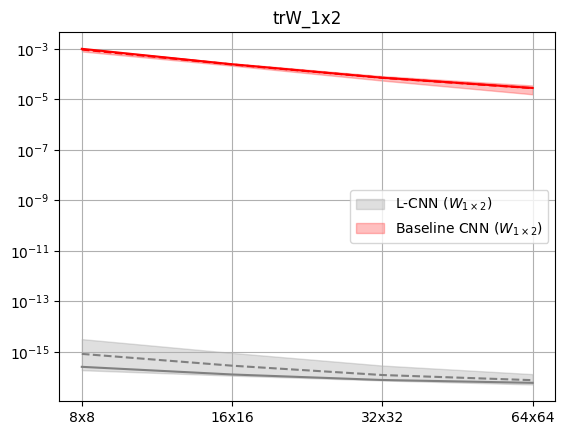

************
Best models of each ensemble according to val_loss
************
************
Scatter plot
************
Test MSE (L-CNN ($W_{1\times2}$)): 1.8602e-16
Test MSE (Baseline CNN ($W_{1\times2}$)): 7.6922e-04


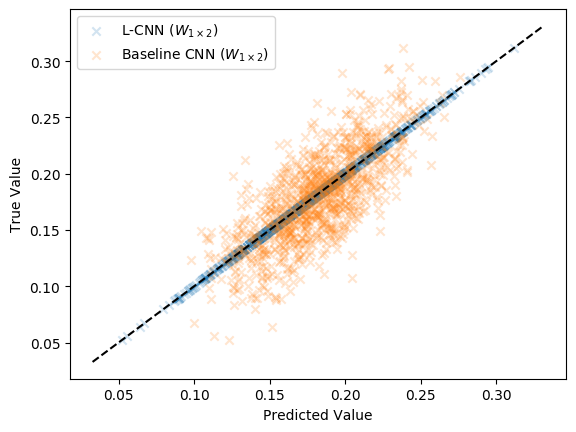

************
Trainable parameters
************
L-CNN ($W_{1\times2}$) 135
Baseline CNN ($W_{1\times2}$) 1237


In [14]:
run_tests(test_d2_w1x2, val_d2_w1x2, mode_out, model_paths, model_labels, model_baselines,
          dataset_paths, dataset_labels, dataset_labels_tex,
          batch_size=50)

# Wilson D2_W1x3

In [15]:
# dataset base path
dataset_path = "../datasets/"

# specific test sets
dataset_paths = [
    dataset_path + "D2_8/test.hdf5",
    dataset_path + "D2_16/test.hdf5",
    dataset_path + "D2_32/test.hdf5",
    dataset_path + "D2_64/test.hdf5"
]

# plot labels for datasets
dataset_labels = [
    "8x8",
    "16x16",
    "32x32",
    "64x64",
]

# dataset labels for tex table
dataset_labels_tex = [
    "$8 \\cdot 8$",
    "$16 \\cdot 16$",
    "$32 \\cdot 32$",
    "$64 \\cdot 64$",
]

# model base path
model_path = "../scripts/"

# model results (lcnns)
model_paths = [
    model_path + "D2_W1x3_lcnn_s_results.pickle",
]

# add baseline model results
model_path_baseline = "../scripts_baseline/"
base_str = "D2_W1x3_baseline_{}_{}_results.pickle"
archs = ["S1"]
activations = ["relu"]

for a in archs:
    for act in activations:
        fp = model_path_baseline + base_str.format(a, act)
        model_paths.append(fp)

# model labels (used for plot labels and result files)
model_labels = [
    "D2_W1x3_lcnn_s",
]

# add baseline labels
archs = ["S1"]
activations = ["relu"]
for a in archs:
    for act in activations:
        label = "D2_W1x3_baseline_{}_{}".format(a, act)
        model_labels.append(label)
        
# whether a model is a baseline or not
model_baselines = [
    False,
]

for a in archs:
    for act in activations:
        model_baselines.append(True)
        
label_map = {
    "D2_W1x3_lcnn_s": "L-CNN ($W_{1\\times3}$)",
    "D2_W1x3_baseline_S1_relu": "Baseline CNN ($W_{1\\times3}$)"
}

model_labels = [label_map.get(label, label) for label in model_labels]

# output mode
mode_out = "trW_1x3"

# output path for pickled results
output_path = "D2_W1x3_results.pickle"
output_val_path = "D2_W1x3_val_results.pickle"
output_scatter_png = "d2_w1x3_scatter.pdf"

In [16]:
if RECOMPUTE_ALL:
    test_d2_w1x3 = compute_test_results(mode_out, model_paths, model_labels, model_baselines,
                                        dataset_paths, dataset_labels, dataset_labels_tex,
                                        output_path, batch_size=5)

************
Test MSEs
************
0 L-CNN ($W_{1\times3}$) 8x8 [8 8] 0.0008514527
1 L-CNN ($W_{1\times3}$) 8x8 [8 8] 0.00084168604
2 L-CNN ($W_{1\times3}$) 8x8 [8 8] 0.0008491849
3 L-CNN ($W_{1\times3}$) 8x8 [8 8] 0.0008400073
4 L-CNN ($W_{1\times3}$) 8x8 [8 8] 0.0008449774
0 L-CNN ($W_{1\times3}$) 16x16 [16 16] 0.00022447767
1 L-CNN ($W_{1\times3}$) 16x16 [16 16] 0.0002199137
2 L-CNN ($W_{1\times3}$) 16x16 [16 16] 0.00022448966
3 L-CNN ($W_{1\times3}$) 16x16 [16 16] 0.00022560944
4 L-CNN ($W_{1\times3}$) 16x16 [16 16] 0.00022029925
0 L-CNN ($W_{1\times3}$) 32x32 [32 32] 6.1423605e-05
1 L-CNN ($W_{1\times3}$) 32x32 [32 32] 5.9466387e-05
2 L-CNN ($W_{1\times3}$) 32x32 [32 32] 6.212144e-05
3 L-CNN ($W_{1\times3}$) 32x32 [32 32] 6.0464852e-05
4 L-CNN ($W_{1\times3}$) 32x32 [32 32] 5.9788257e-05
0 L-CNN ($W_{1\times3}$) 64x64 [64 64] 2.5931857e-05
1 L-CNN ($W_{1\times3}$) 64x64 [64 64] 2.4522196e-05
2 L-CNN ($W_{1\times3}$) 64x64 [64 64] 2.6596326e-05
3 L-CNN ($W_{1\times3}$) 64x64 [64 6

In [17]:
if RECOMPUTE_ALL:
    val_d2_w1x3 = compute_val_results(mode_out, model_paths, model_labels, model_baselines,
                                      output_val_path, batch_size=5)

************
Validation MSEs
************
0 L-CNN ($W_{1\times3}$) 0.00089789653
1 L-CNN ($W_{1\times3}$) 0.00088580645
2 L-CNN ($W_{1\times3}$) 0.0008973271
3 L-CNN ($W_{1\times3}$) 0.0008934247
4 L-CNN ($W_{1\times3}$) 0.0008905735
0 Baseline CNN ($W_{1\times3}$) 0.0014951774
1 Baseline CNN ($W_{1\times3}$) 0.001696292
2 Baseline CNN ($W_{1\times3}$) 0.0016963168
3 Baseline CNN ($W_{1\times3}$) 0.0016962752
4 Baseline CNN ($W_{1\times3}$) 0.0014400587


In [18]:
if not RECOMPUTE_ALL:
    test_d2_w1x3 = pickle.load(open(output_path, "rb"))
    val_d2_w1x3 = pickle.load(open(output_val_path, "rb"))

************
MSE plots
************


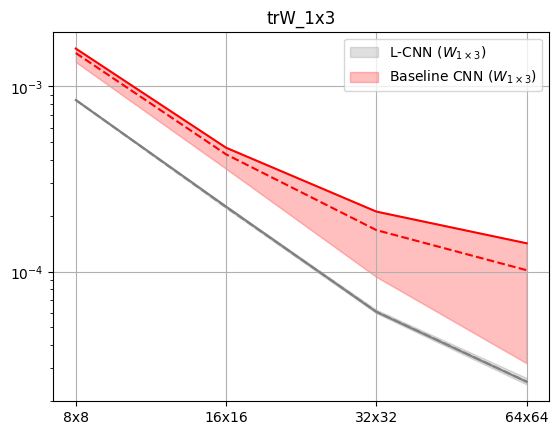

************
Best models of each ensemble according to val_loss
************
************
Scatter plot
************
Test MSE (L-CNN ($W_{1\times3}$)): 8.4169e-04
Test MSE (Baseline CNN ($W_{1\times3}$)): 1.3547e-03


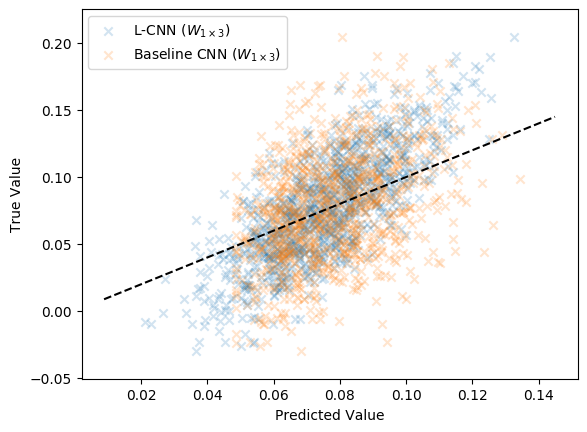

************
Trainable parameters
************
L-CNN ($W_{1\times3}$) 185
Baseline CNN ($W_{1\times3}$) 1249


In [19]:
run_tests(test_d2_w1x3, val_d2_w1x3, mode_out, model_paths, model_labels, model_baselines,
          dataset_paths, dataset_labels, dataset_labels_tex,
          batch_size=50)

# Wilson D2_W2x2

In [20]:
# dataset base path
dataset_path = "../datasets/"

# specific test sets
dataset_paths = [
    dataset_path + "D2_8/test.hdf5",
    dataset_path + "D2_16/test.hdf5",
    dataset_path + "D2_32/test.hdf5",
    dataset_path + "D2_64/test.hdf5"
]

# override train, val and test sets
override_dataset_paths = {
    'train': dataset_path + "D2_8/train.hdf5",
    'val': dataset_path + "D2_8/val.hdf5",
    'test': dataset_path + "D2_8/test.hdf5"
}

# plot labels for datasets
dataset_labels = [
    "8x8",
    "16x16",
    "32x32",
    "64x64",
]

# dataset labels for tex table
dataset_labels_tex = [
    "$8 \\cdot 8$",
    "$16 \\cdot 16$",
    "$32 \\cdot 32$",
    "$64 \\cdot 64$",
]

# model base path
model_path = "../scripts/"

# model results (lcnns)
model_paths = [
    model_path + "D2_W2x2_lcnn_s_results.pickle",
]

# add baseline model results
model_path_baseline = "../scripts_baseline/"
base_str = "D2_W2x2_baseline_{}_{}_results.pickle"
archs = ["S1"]
activations = ["relu"]

for a in archs:
    for act in activations:
        fp = model_path_baseline + base_str.format(a, act)
        model_paths.append(fp)

# model labels (used for plot labels and result files)
model_labels = [
    "D2_W2x2_lcnn_s",
]

# add baseline labels
archs = ["S1"]
activations = ["relu"]
for a in archs:
    for act in activations:
        label = "D2_W2x2_baseline_{}_{}".format(a, act)
        model_labels.append(label)

# whether a model is a baseline or not
model_baselines = [
    False,
]

for a in archs:
    for act in activations:
        model_baselines.append(True)
        
label_map = {
    "D2_W2x2_lcnn_s": "L-CNN ($W_{2\\times2}$)",
    "D2_W2x2_baseline_S1_relu": "Baseline CNN ($W_{2\\times2}$)"
}

model_labels = [label_map.get(label, label) for label in model_labels]

# output mode
mode_out = "trW_2x2"

# output path for pickled results
output_path = "D2_W2x2_results.pickle"
output_val_path = "D2_W2x2_val_results.pickle"
output_scatter_png = "d2_w2x2_scatter.pdf"

In [21]:
if RECOMPUTE_ALL:
    test_d2_w2x2 = compute_test_results(mode_out, model_paths, model_labels, model_baselines,
                                        dataset_paths, dataset_labels, dataset_labels_tex,
                                        output_path, batch_size=5)

************
Test MSEs
************
0 L-CNN ($W_{2\times2}$) 8x8 [8 8] 2.3674829e-09
1 L-CNN ($W_{2\times2}$) 8x8 [8 8] 1.3779654e-08
2 L-CNN ($W_{2\times2}$) 8x8 [8 8] 8.699881e-14
3 L-CNN ($W_{2\times2}$) 8x8 [8 8] 1.1372353e-09
4 L-CNN ($W_{2\times2}$) 8x8 [8 8] 4.445559e-10
0 L-CNN ($W_{2\times2}$) 16x16 [16 16] 5.8390653e-10
1 L-CNN ($W_{2\times2}$) 16x16 [16 16] 3.53176e-09
2 L-CNN ($W_{2\times2}$) 16x16 [16 16] 2.3853473e-14
3 L-CNN ($W_{2\times2}$) 16x16 [16 16] 2.7593852e-10
4 L-CNN ($W_{2\times2}$) 16x16 [16 16] 1.3433771e-10
0 L-CNN ($W_{2\times2}$) 32x32 [32 32] 1.6604364e-10
1 L-CNN ($W_{2\times2}$) 32x32 [32 32] 1.0399454e-09
2 L-CNN ($W_{2\times2}$) 32x32 [32 32] 6.456709e-15
3 L-CNN ($W_{2\times2}$) 32x32 [32 32] 7.7381566e-11
4 L-CNN ($W_{2\times2}$) 32x32 [32 32] 6.725492e-11
0 L-CNN ($W_{2\times2}$) 64x64 [64 64] 5.062439e-11
1 L-CNN ($W_{2\times2}$) 64x64 [64 64] 3.6294914e-10
2 L-CNN ($W_{2\times2}$) 64x64 [64 64] 2.7222608e-15
3 L-CNN ($W_{2\times2}$) 64x64 [64 64

In [22]:
if RECOMPUTE_ALL:
    val_d2_w2x2 = compute_val_results(mode_out, model_paths, model_labels, model_baselines,
                                      output_val_path, batch_size=5)

************
Validation MSEs
************
0 L-CNN ($W_{2\times2}$) 2.3577669e-09
1 L-CNN ($W_{2\times2}$) 1.42130006e-08
2 L-CNN ($W_{2\times2}$) 8.976451e-14
3 L-CNN ($W_{2\times2}$) 1.0134311e-09
4 L-CNN ($W_{2\times2}$) 4.8927207e-10
0 Baseline CNN ($W_{2\times2}$) 0.0010937145
1 Baseline CNN ($W_{2\times2}$) 0.001082876
2 Baseline CNN ($W_{2\times2}$) 0.0010099988
3 Baseline CNN ($W_{2\times2}$) 0.0010934825
4 Baseline CNN ($W_{2\times2}$) 0.0010553374


In [23]:
if not RECOMPUTE_ALL:
    test_d2_w2x2 = pickle.load(open(output_path, "rb"))
    val_d2_w2x2 = pickle.load(open(output_val_path, "rb"))

************
MSE plots
************


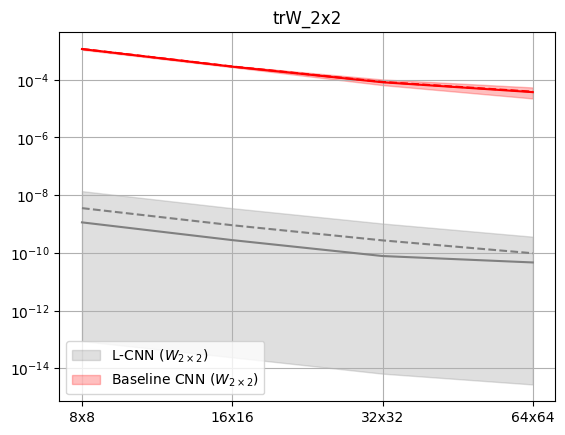

************
Best models of each ensemble according to val_loss
************
************
Scatter plot
************
Test MSE (L-CNN ($W_{2\times2}$)): 8.6999e-14
Test MSE (Baseline CNN ($W_{2\times2}$)): 1.1023e-03


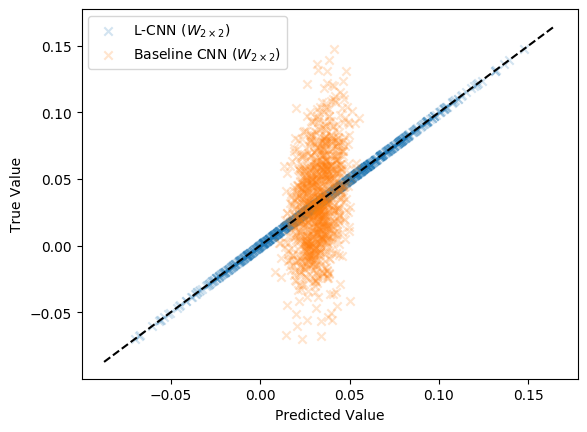

************
Trainable parameters
************
L-CNN ($W_{2\times2}$) 265
Baseline CNN ($W_{2\times2}$) 1249


In [24]:
run_tests(test_d2_w2x2, val_d2_w2x2, mode_out, model_paths, model_labels, model_baselines,
          dataset_paths, dataset_labels, dataset_labels_tex,
          batch_size=50)

# Wilson_D2_W2x3

In [25]:
# dataset base path
dataset_path = "../datasets/"

# specific test sets
dataset_paths = [
    dataset_path + "D2_8/test.hdf5",
    dataset_path + "D2_16/test.hdf5",
    dataset_path + "D2_32/test.hdf5",
    dataset_path + "D2_64/test.hdf5"
]

# plot labels for datasets
dataset_labels = [
    "8x8",
    "16x16",
    "32x32",
    "64x64",
]

# dataset labels for tex table
dataset_labels_tex = [
    "$8 \\cdot 8$",
    "$16 \\cdot 16$",
    "$32 \\cdot 32$",
    "$64 \\cdot 64$",
]

# model base path
model_path = "../scripts/"

# model results (lcnns)
model_paths = [
    model_path + "D2_W2x3_lcnn_s_results.pickle",
]

# add baseline model results
model_path_baseline = "../scripts_baseline/"
base_str = "D2_W2x3_baseline_{}_{}_results.pickle"
archs = ["S1"]
activations = ["relu"]

for a in archs:
    for act in activations:
        fp = model_path_baseline + base_str.format(a, act)
        model_paths.append(fp)

# model labels (used for plot labels and result files)
model_labels = [
    "D2_W2x3_lcnn_s",
]

# add baseline labels
archs = ["S1"]
activations = ["relu"]
for a in archs:
    for act in activations:
        label = "D2_W2x3_baseline_{}_{}".format(a, act)
        model_labels.append(label)
        
# whether a model is a baseline or not
model_baselines = [
    False,
]

for a in archs:
    for act in activations:
        model_baselines.append(True)
        
label_map = {
    "D2_W2x3_lcnn_s": "L-CNN ($W_{2\\times3}$)",
    "D2_W2x3_baseline_S1_relu": "Baseline CNN ($W_{2\\times3}$)"
}

model_labels = [label_map.get(label, label) for label in model_labels]

# output mode
mode_out = "trW_2x3"

# output path for pickled results
output_path = "D2_W2x3_results.pickle"
output_val_path = "D2_W2x3_val_results.pickle"
output_scatter_png = "d2_w2x3_scatter.pdf"

In [26]:
if RECOMPUTE_ALL:
    test_d2_w2x3 = compute_test_results(mode_out, model_paths, model_labels, model_baselines,
                                        dataset_paths, dataset_labels, dataset_labels_tex,
                                        output_path, batch_size=5)

************
Test MSEs
************
0 L-CNN ($W_{2\times3}$) 8x8 [8 8] 0.0008263046
1 L-CNN ($W_{2\times3}$) 8x8 [8 8] 0.0008244253
2 L-CNN ($W_{2\times3}$) 8x8 [8 8] 0.0008222371
3 L-CNN ($W_{2\times3}$) 8x8 [8 8] 0.00084002136
4 L-CNN ($W_{2\times3}$) 8x8 [8 8] 0.0008209733
0 L-CNN ($W_{2\times3}$) 16x16 [16 16] 0.00021223926
1 L-CNN ($W_{2\times3}$) 16x16 [16 16] 0.0002057491
2 L-CNN ($W_{2\times3}$) 16x16 [16 16] 0.00020754502
3 L-CNN ($W_{2\times3}$) 16x16 [16 16] 0.00022254228
4 L-CNN ($W_{2\times3}$) 16x16 [16 16] 0.00020496223
0 L-CNN ($W_{2\times3}$) 32x32 [32 32] 5.4496126e-05
1 L-CNN ($W_{2\times3}$) 32x32 [32 32] 5.0137758e-05
2 L-CNN ($W_{2\times3}$) 32x32 [32 32] 5.084958e-05
3 L-CNN ($W_{2\times3}$) 32x32 [32 32] 6.228144e-05
4 L-CNN ($W_{2\times3}$) 32x32 [32 32] 4.9417908e-05
0 L-CNN ($W_{2\times3}$) 64x64 [64 64] 1.8323391e-05
1 L-CNN ($W_{2\times3}$) 64x64 [64 64] 1.3517674e-05
2 L-CNN ($W_{2\times3}$) 64x64 [64 64] 1.4543667e-05
3 L-CNN ($W_{2\times3}$) 64x64 [64 64

In [27]:
if RECOMPUTE_ALL:
    val_d2_w2x3 = compute_val_results(mode_out, model_paths, model_labels, model_baselines,
                                      output_val_path, batch_size=5)

************
Validation MSEs
************
0 L-CNN ($W_{2\times3}$) 0.0008219446
1 L-CNN ($W_{2\times3}$) 0.00082286954
2 L-CNN ($W_{2\times3}$) 0.00082153996
3 L-CNN ($W_{2\times3}$) 0.0008319835
4 L-CNN ($W_{2\times3}$) 0.00082272344
0 Baseline CNN ($W_{2\times3}$) 0.0009591907
1 Baseline CNN ($W_{2\times3}$) 0.0009590628
2 Baseline CNN ($W_{2\times3}$) 0.00096472143
3 Baseline CNN ($W_{2\times3}$) 0.0009589782
4 Baseline CNN ($W_{2\times3}$) 0.0009589771


In [28]:
if not RECOMPUTE_ALL:
    test_d2_w2x3 = pickle.load(open(output_path, "rb"))
    val_d2_w2x3 = pickle.load(open(output_val_path, "rb"))

************
MSE plots
************


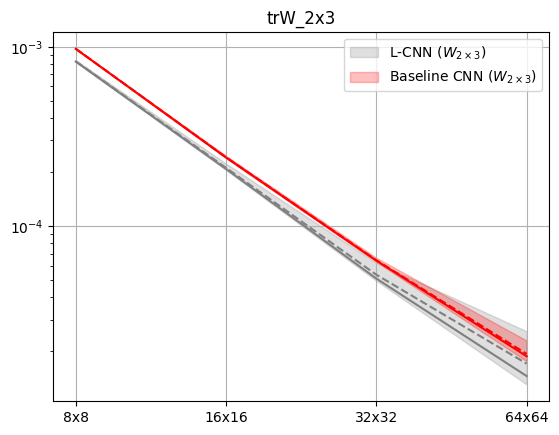

************
Best models of each ensemble according to val_loss
************
************
Scatter plot
************
Test MSE (L-CNN ($W_{2\times3}$)): 8.2224e-04
Test MSE (Baseline CNN ($W_{2\times3}$)): 9.7046e-04


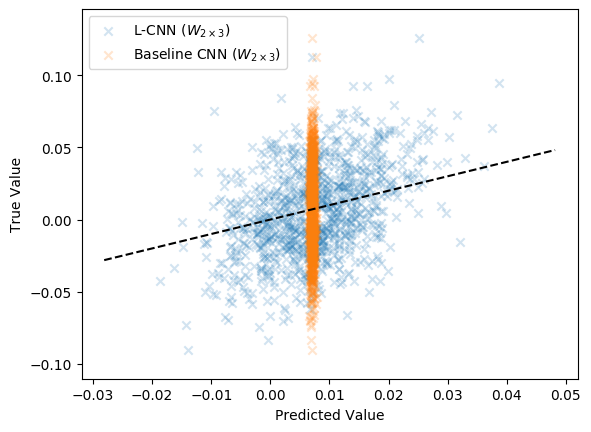

************
Trainable parameters
************
L-CNN ($W_{2\times3}$) 399
Baseline CNN ($W_{2\times3}$) 1317


In [29]:
run_tests(test_d2_w2x3, val_d2_w2x3, mode_out, model_paths, model_labels, model_baselines,
          dataset_paths, dataset_labels, dataset_labels_tex,
          batch_size=50)

# Wilson D2_3x3

In [30]:
# dataset base path
dataset_path = "../datasets/"

# specific test sets
dataset_paths = [
    dataset_path + "D2_8/test.hdf5",
    dataset_path + "D2_16/test.hdf5",
    dataset_path + "D2_32/test.hdf5",
    dataset_path + "D2_64/test.hdf5"
]

# plot labels for datasets
dataset_labels = [
    "8x8",
    "16x16",
    "32x32",
    "64x64",
]

# dataset labels for tex table
dataset_labels_tex = [
    "$8 \\cdot 8$",
    "$16 \\cdot 16$",
    "$32 \\cdot 32$",
    "$64 \\cdot 64$",
]

# model base path
model_path = "../scripts/"

# model results (lcnns)
model_paths = [
    model_path + "D2_W3x3_lcnn_s_results.pickle",
]

# add baseline model results
model_path_baseline = "../scripts_baseline/"
base_str = "D2_W3x3_baseline_{}_{}_results.pickle"
archs = ["S1"]
activations = ["relu"]

for a in archs:
    for act in activations:
        fp = model_path_baseline + base_str.format(a, act)
        model_paths.append(fp)

# model labels (used for plot labels and result files)
model_labels = [
    "D2_W3x3_lcnn_s",
]

# add baseline labels
archs = ["S1"]
activations = ["relu"]
for a in archs:
    for act in activations:
        label = "D2_W3x3_baseline_{}_{}".format(a, act)
        model_labels.append(label)
        
# whether a model is a baseline or not
model_baselines = [
    False,
]

for a in archs:
    for act in activations:
        model_baselines.append(True)
        
label_map = {
    "D2_W3x3_lcnn_s": "L-CNN ($W_{3\\times3}$)",
    "D2_W3x3_baseline_S1_relu": "Baseline CNN ($W_{3\\times3}$)"
}

model_labels = [label_map.get(label, label) for label in model_labels]

# output mode
mode_out = "trW_3x3"

# output path for pickled results
output_path = "D2_W3x3_results.pickle"
output_val_path = "D2_W3x3_val_results.pickle"
output_scatter_png = "d2_w3x3_scatter.pdf"

In [31]:
if RECOMPUTE_ALL:
    test_d2_w3x3 = compute_test_results(mode_out, model_paths, model_labels, model_baselines,
                                        dataset_paths, dataset_labels, dataset_labels_tex,
                                        output_path, batch_size=5)

************
Test MSEs
************
0 L-CNN ($W_{3\times3}$) 8x8 [8 8] 1.0971495e-06
1 L-CNN ($W_{3\times3}$) 8x8 [8 8] 0.0008804071
2 L-CNN ($W_{3\times3}$) 8x8 [8 8] 0.00024045116
3 L-CNN ($W_{3\times3}$) 8x8 [8 8] 1.3627498e-09
4 L-CNN ($W_{3\times3}$) 8x8 [8 8] 0.00088504155
0 L-CNN ($W_{3\times3}$) 16x16 [16 16] 3.332613e-07
1 L-CNN ($W_{3\times3}$) 16x16 [16 16] 0.00022294658
2 L-CNN ($W_{3\times3}$) 16x16 [16 16] 5.4599408e-05
3 L-CNN ($W_{3\times3}$) 16x16 [16 16] 5.067341e-10
4 L-CNN ($W_{3\times3}$) 16x16 [16 16] 0.00022247848
0 L-CNN ($W_{3\times3}$) 32x32 [32 32] 1.1304078e-07
1 L-CNN ($W_{3\times3}$) 32x32 [32 32] 5.611884e-05
2 L-CNN ($W_{3\times3}$) 32x32 [32 32] 1.4756753e-05
3 L-CNN ($W_{3\times3}$) 32x32 [32 32] 2.5777125e-10
4 L-CNN ($W_{3\times3}$) 32x32 [32 32] 5.673941e-05
0 L-CNN ($W_{3\times3}$) 64x64 [64 64] 5.260529e-08
1 L-CNN ($W_{3\times3}$) 64x64 [64 64] 1.2529396e-05
2 L-CNN ($W_{3\times3}$) 64x64 [64 64] 3.7095813e-06
3 L-CNN ($W_{3\times3}$) 64x64 [64 6

In [32]:
if RECOMPUTE_ALL:
    val_d2_w3x3 = compute_val_results(mode_out, model_paths, model_labels, model_baselines,
                                      output_val_path, batch_size=5)

************
Validation MSEs
************
0 L-CNN ($W_{3\times3}$) 1.1527821e-06
1 L-CNN ($W_{3\times3}$) 0.00088650524
2 L-CNN ($W_{3\times3}$) 0.00021822727
3 L-CNN ($W_{3\times3}$) 1.387245e-09
4 L-CNN ($W_{3\times3}$) 0.0008883457
0 Baseline CNN ($W_{3\times3}$) 0.00088837347
1 Baseline CNN ($W_{3\times3}$) 0.0008884024
2 Baseline CNN ($W_{3\times3}$) 0.0008887527
3 Baseline CNN ($W_{3\times3}$) 0.00089039025
4 Baseline CNN ($W_{3\times3}$) 0.00088804436


In [33]:
if not RECOMPUTE_ALL:
    test_d2_w3x3 = pickle.load(open(output_path, "rb"))
    val_d2_w3x3 = pickle.load(open(output_val_path, "rb"))

************
MSE plots
************


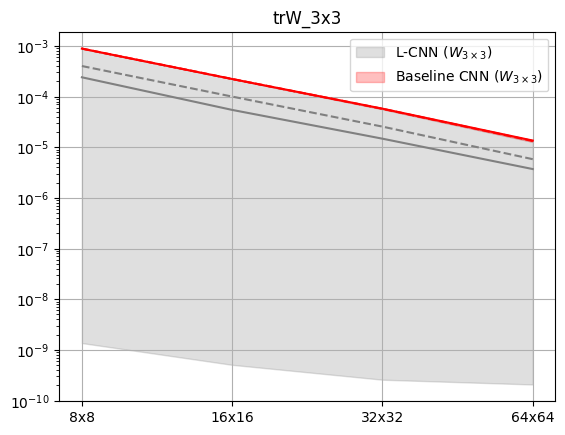

************
Best models of each ensemble according to val_loss
************
************
Scatter plot
************
Test MSE (L-CNN ($W_{3\times3}$)): 1.3627e-09
Test MSE (Baseline CNN ($W_{3\times3}$)): 8.8557e-04


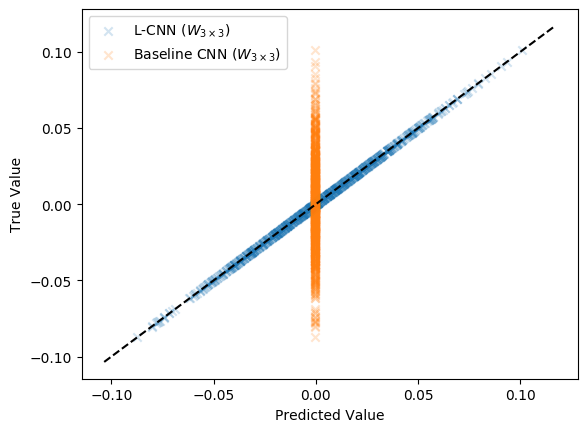

************
Trainable parameters
************
L-CNN ($W_{3\times3}$) 525
Baseline CNN ($W_{3\times3}$) 1293


In [34]:
run_tests(test_d2_w3x3, val_d2_w3x3, mode_out, model_paths, model_labels, model_baselines,
          dataset_paths, dataset_labels, dataset_labels_tex,
          batch_size=50)

# Wilson D2_4x4

In [35]:
# dataset base path
dataset_path = "../datasets/"

# specific test sets
dataset_paths = [
    dataset_path + "D2_8/test.hdf5",
    dataset_path + "D2_16/test.hdf5",
    dataset_path + "D2_32/test.hdf5",
    dataset_path + "D2_64/test.hdf5"
]

# plot labels for datasets
dataset_labels = [
    "8x8",
    "16x16",
    "32x32",
    "64x64",
]

# dataset labels for tex table
dataset_labels_tex = [
    "$8 \\cdot 8$",
    "$16 \\cdot 16$",
    "$32 \\cdot 32$",
    "$64 \\cdot 64$",
]

# model base path
model_path = "../scripts/"

# model results (lcnns)
model_paths = [
    model_path + "D2_W4x4_lcnn_s_results.pickle",
    model_path + "D2_W4x4_lcnn_m_results.pickle",
    model_path + "D2_W4x4_lcnn_l_results.pickle",
    model_path + "D2_W4x4_lcnn_max_results.pickle",
]

# add baseline model results
model_path_baseline = "../scripts_baseline/"
base_str = "D2_W4x4_baseline_{}_{}_results.pickle"
archs = ["S1"]
activations = ["relu"]

for a in archs:
    for act in activations:
        fp = model_path_baseline + base_str.format(a, act)
        model_paths.append(fp)

# model labels (used for plot labels and result files)
model_labels = [
    "D2_W4x4_lcnn_s",
    "D2_W4x4_lcnn_m",
    "D2_W4x4_lcnn_l",
    "D2_W4x4_lcnn_max",
]

# add baseline labels
archs = ["S1"]
activations = ["relu"]
for a in archs:
    for act in activations:
        label = "D2_W4x4_baseline_{}_{}".format(a, act)
        model_labels.append(label)

# whether a model is a baseline or not
model_baselines = [
    False,
    False,
    False,
    False,
]

for a in archs:
    for act in activations:
        model_baselines.append(True)
        
label_map = {
    "D2_W4x4_lcnn_s": "L-CNN (Small)",
    "D2_W4x4_lcnn_m": "L-CNN (Medium)",
    "D2_W4x4_lcnn_l": "L-CNN (Large)",
    "D2_W4x4_lcnn_max": "L-CNN (Max)",
    "D2_W4x4_baseline_S1_relu": "Baseline CNN"
}

model_labels = [label_map.get(label, label) for label in model_labels]
        
# output mode
mode_out = "trW_4x4"

# output path for pickled results
output_path = "D2_W4x4_results.pickle"
output_val_path = "D2_W4x4_val_results.pickle"
output_scatter_png = "d4_w4x4_scatter.pdf"

In [36]:
if RECOMPUTE_ALL:
    test_d2_w4x4 = compute_test_results(mode_out, model_paths, model_labels, model_baselines,
                                        dataset_paths, dataset_labels, dataset_labels_tex,
                                        output_path, batch_size=1)

************
Test MSEs
************
0 L-CNN (Small) 8x8 [8 8] 0.00089127786
0 L-CNN (Small) 16x16 [16 16] 0.0002276165
0 L-CNN (Small) 32x32 [32 32] 5.1520405e-05
0 L-CNN (Small) 64x64 [64 64] 1.3509705e-05
0 L-CNN (Medium) 8x8 [8 8] 0.0008889321
0 L-CNN (Medium) 16x16 [16 16] 0.00022696661
0 L-CNN (Medium) 32x32 [32 32] 5.184783e-05
0 L-CNN (Medium) 64x64 [64 64] 1.3436446e-05
0 L-CNN (Large) 8x8 [8 8] 0.00094670296
0 L-CNN (Large) 16x16 [16 16] 0.0002655388
0 L-CNN (Large) 32x32 [32 32] 8.611989e-05
0 L-CNN (Large) 64x64 [64 64] 5.1148752e-05
0 L-CNN (Max) 8x8 [8 8] 0.0009004468
0 L-CNN (Max) 16x16 [16 16] 0.00024450046
0 L-CNN (Max) 32x32 [32 32] 7.115057e-05
0 L-CNN (Max) 64x64 [64 64] 3.0650786e-05
0 Baseline CNN 8x8 [8 8] 0.0008922336
0 Baseline CNN 16x16 [16 16] 0.00022799705
0 Baseline CNN 32x32 [32 32] 5.20669e-05
0 Baseline CNN 64x64 [64 64] 1.4373615e-05


In [37]:
if RECOMPUTE_ALL:
    val_d2_w4x4 = compute_val_results(mode_out, model_paths, model_labels, model_baselines,
                                      output_val_path, batch_size=2)

************
Validation MSEs
************
0 L-CNN (Small) 0.0007872219
0 L-CNN (Medium) 0.0007909882
0 L-CNN (Large) 0.00082568114
0 L-CNN (Max) 0.00081365
0 Baseline CNN 0.0007883686


In [38]:
if not RECOMPUTE_ALL:
    test_d2_w4x4 = pickle.load(open(output_path, "rb"))
    val_d2_w4x4 = pickle.load(open(output_val_path, "rb"))

************
MSE plots
************


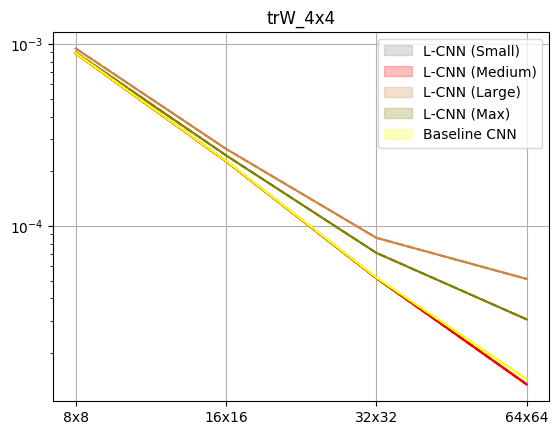

************
Best models of each ensemble according to val_loss
************
************
Scatter plot
************
Test MSE (L-CNN (Small)): 8.9128e-04
Test MSE (L-CNN (Medium)): 8.8893e-04
Test MSE (L-CNN (Large)): 9.4670e-04
Test MSE (L-CNN (Max)): 9.0045e-04
Test MSE (Baseline CNN): 8.9223e-04


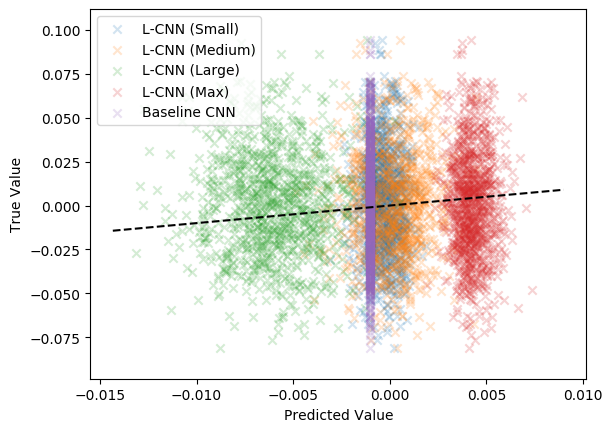

************
Trainable parameters
************
L-CNN (Small) 685
L-CNN (Medium) 11617
L-CNN (Large) 47281
L-CNN (Max) 78017
Baseline CNN 1329


In [39]:
run_tests(test_d2_w4x4, val_d2_w4x4, mode_out, model_paths, model_labels, model_baselines,
          dataset_paths, dataset_labels, dataset_labels_tex,
          batch_size=50)

# Wilson D2_4x4_large

In [40]:
# dataset base path
dataset_path = "../datasetslarge/"

# specific test sets
dataset_paths = [
    dataset_path + "D2_8/test.hdf5",
    dataset_path + "D2_16/test.hdf5",
    dataset_path + "D2_32/test.hdf5",
    dataset_path + "D2_64/test.hdf5"
]

# plot labels for datasets
dataset_labels = [
    "8x8",
    "16x16",
    "32x32",
    "64x64",
]

# dataset labels for tex table
dataset_labels_tex = [
    "$8 \\cdot 8$",
    "$16 \\cdot 16$",
    "$32 \\cdot 32$",
    "$64 \\cdot 64$",
]

# model base path
model_path = "../scripts/"

# model results (lcnns)
model_paths = [
    model_path + "D2_W4x4_lcnn_s_large_results.pickle",
    model_path + "D2_W4x4_lcnn_m_large_results.pickle",
]

# add baseline model results
model_path_baseline = "../scripts_baseline/"
base_str = "D2_W4x4_baseline_{}_{}_large_results.pickle"
archs = ["S1"]
activations = ["relu"]

for a in archs:
    for act in activations:
        fp = model_path_baseline + base_str.format(a, act)
        model_paths.append(fp)

# model labels (used for plot labels and result files)
model_labels = [
    "D2_W4x4_lcnn_s_large",
    "D2_W4x4_lcnn_m_large",
]

# add baseline labels
archs = ["S1"]
activations = ["relu"]
for a in archs:
    for act in activations:
        label = "D2_W4x4_baseline_{}_{}_large".format(a, act)
        model_labels.append(label)

# whether a model is a baseline or not
model_baselines = [
    False,
    False,
]

for a in archs:
    for act in activations:
        model_baselines.append(True)
        
label_map = {
    "D2_W4x4_lcnn_s_large": "L-CNN (Small)",
    "D2_W4x4_lcnn_m_large": "L-CNN (Medium)",
    "D2_W4x4_baseline_S1_relu_large": "Baseline CNN"
}

model_labels = [label_map.get(label, label) for label in model_labels]
        
# output mode
mode_out = "trW_4x4"

# output path for pickled results
output_path = "D2_W4x4_results_large_m.pickle"
output_val_path = "D2_W4x4_val_results_large_m.pickle"
output_scatter_png = "d4_w4x4_scatter_large_m.pdf"

In [41]:
if RECOMPUTE_ALL:
    test_d2_w4x4_m = compute_test_results(mode_out, model_paths, model_labels, model_baselines,
                                        dataset_paths, dataset_labels, dataset_labels_tex,
                                        output_path, batch_size=1)

************
Test MSEs
************
0 L-CNN (Small) 8x8 [8 8] 0.0008725393
0 L-CNN (Small) 16x16 [16 16] 0.00021745774
0 L-CNN (Small) 32x32 [32 32] 5.3090618e-05
0 L-CNN (Small) 64x64 [64 64] 1.4770666e-05
0 L-CNN (Medium) 8x8 [8 8] 0.0008809699
0 L-CNN (Medium) 16x16 [16 16] 0.00021923947
0 L-CNN (Medium) 32x32 [32 32] 5.5437544e-05
0 L-CNN (Medium) 64x64 [64 64] 1.6978867e-05
0 Baseline CNN 8x8 [8 8] 0.00087402493
0 Baseline CNN 16x16 [16 16] 0.00021738194
0 Baseline CNN 32x32 [32 32] 5.3074826e-05
0 Baseline CNN 64x64 [64 64] 1.4673524e-05


In [42]:
if RECOMPUTE_ALL:
    val_d2_w4x4_m = compute_val_results(mode_out, model_paths, model_labels, model_baselines,
                                      output_val_path, batch_size=2)

************
Validation MSEs
************
0 L-CNN (Small) 0.00080812833
0 L-CNN (Medium) 0.0008093702
0 Baseline CNN 0.0008079005


In [43]:
if not RECOMPUTE_ALL:
    test_d2_w4x4_m = pickle.load(open(output_path, "rb"))
    val_d2_w4x4_m = pickle.load(open(output_val_path, "rb"))

************
MSE plots
************


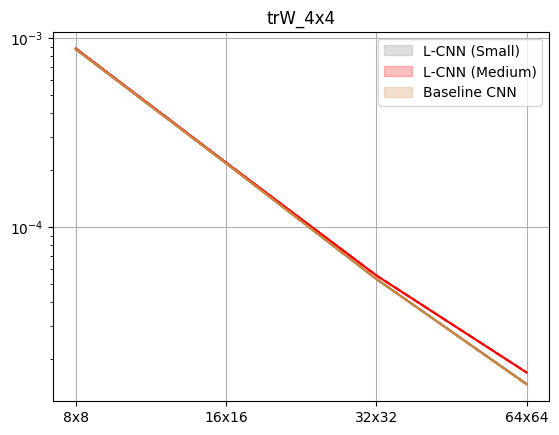

************
Best models of each ensemble according to val_loss
************
************
Scatter plot
************
Test MSE (L-CNN (Small)): 8.7254e-04
Test MSE (L-CNN (Medium)): 8.8097e-04
Test MSE (Baseline CNN): 8.7402e-04


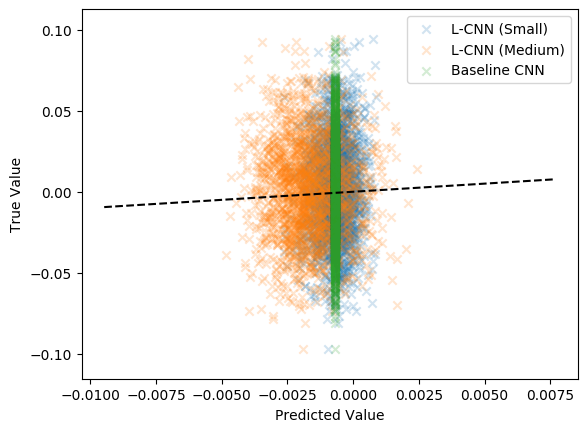

************
Trainable parameters
************
L-CNN (Small) 685
L-CNN (Medium) 11617
Baseline CNN 1329


In [44]:
run_tests(test_d2_w4x4_m, val_d2_w4x4_m, mode_out, model_paths, model_labels, model_baselines,
          dataset_paths, dataset_labels, dataset_labels_tex,
          batch_size=50)

# Wilson D2_4x4_16x16

In [45]:
# dataset base path
dataset_path = "../datasets/"

# specific test sets
dataset_paths = [
    dataset_path + "D2_8/test.hdf5",
    dataset_path + "D2_16/test.hdf5",
    dataset_path + "D2_32/test.hdf5",
    dataset_path + "D2_64/test.hdf5"
]

# plot labels for datasets
dataset_labels = [
    "8x8",
    "16x16",
    "32x32",
    "64x64",
]

# dataset labels for tex table
dataset_labels_tex = [
    "$8 \\cdot 8$",
    "$16 \\cdot 16$",
    "$32 \\cdot 32$",
    "$64 \\cdot 64$",
]

# model base path
model_path = "../scripts/"

# model results (lcnns)
model_paths = [
    model_path + "D2_W4x4_lcnn_s_16x16_results.pickle",
    model_path + "D2_W4x4_lcnn_m_16x16_results.pickle",
]

# add baseline model results
model_path_baseline = "../scripts_baseline/"
base_str = "D2_W4x4_baseline_{}_{}_16x16_results.pickle"
archs = ["S1"]
activations = ["relu"]

for a in archs:
    for act in activations:
        fp = model_path_baseline + base_str.format(a, act)
        model_paths.append(fp)

# model labels (used for plot labels and result files)
model_labels = [
    "D2_W4x4_lcnn_s_16x16",
    "D2_W4x4_lcnn_m_16x16",
]

# add baseline labels
archs = ["S1"]
activations = ["relu"]
for a in archs:
    for act in activations:
        label = "D2_W4x4_baseline_{}_{}_16x16".format(a, act)
        model_labels.append(label)

# whether a model is a baseline or not
model_baselines = [
    False,
    False,
]

for a in archs:
    for act in activations:
        model_baselines.append(True)
        
label_map = {
    "D2_W4x4_lcnn_s_16x16": "L-CNN (Small)",
    "D2_W4x4_lcnn_m_16x16": "L-CNN (Medium)",
    "D2_W4x4_baseline_S1_relu_16x16": "Baseline CNN"
}

model_labels = [label_map.get(label, label) for label in model_labels]
        
# output mode
mode_out = "trW_4x4"

# output path for pickled results
output_path = "D2_W4x4_results_large_16.pickle"
output_val_path = "D2_W4x4_val_results_large_16.pickle"
output_scatter_png = "d4_w4x4_scatter_large_16.pdf"

In [46]:
if RECOMPUTE_ALL:
    test_d2_w4x4_16 = compute_test_results(mode_out, model_paths, model_labels, model_baselines,
                                        dataset_paths, dataset_labels, dataset_labels_tex,
                                        output_path, batch_size=1)

************
Test MSEs
************
0 L-CNN (Small) 8x8 [8 8] 0.0008942451
0 L-CNN (Small) 16x16 [16 16] 0.000227817
0 L-CNN (Small) 32x32 [32 32] 5.157446e-05
0 L-CNN (Small) 64x64 [64 64] 1.3321267e-05
0 L-CNN (Medium) 8x8 [8 8] 0.00089308736
0 L-CNN (Medium) 16x16 [16 16] 0.00022807746
0 L-CNN (Medium) 32x32 [32 32] 5.199436e-05
0 L-CNN (Medium) 64x64 [64 64] 1.4390532e-05
0 Baseline CNN 8x8 [8 8] 0.0008887703
0 Baseline CNN 16x16 [16 16] 0.00022704524
0 Baseline CNN 32x32 [32 32] 5.1741226e-05
0 Baseline CNN 64x64 [64 64] 1.3348264e-05


In [47]:
if RECOMPUTE_ALL:
    val_d2_w4x4_16 = compute_val_results(mode_out, model_paths, model_labels, model_baselines,
                                      output_val_path, batch_size=2)

************
Validation MSEs
************
0 L-CNN (Small) 0.00020743787
0 L-CNN (Medium) 0.00020928295
0 Baseline CNN 0.0002069806


In [48]:
if not RECOMPUTE_ALL:
    test_d2_w4x4_16 = pickle.load(open(output_path, "rb"))
    val_d2_w4x4_16 = pickle.load(open(output_val_path, "rb"))

************
MSE plots
************


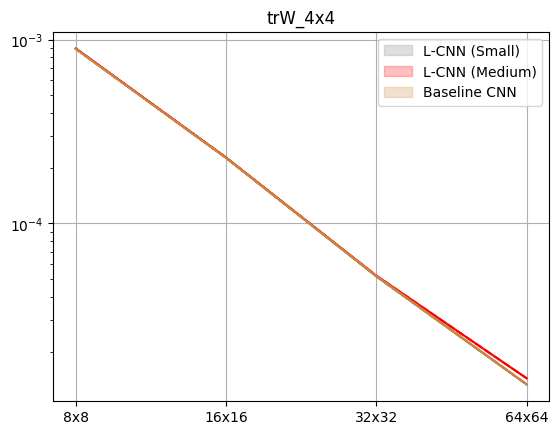

************
Best models of each ensemble according to val_loss
************
************
Scatter plot
************
Test MSE (L-CNN (Small)): 2.1421e-04
Test MSE (L-CNN (Medium)): 2.1384e-04
Test MSE (Baseline CNN): 2.1415e-04


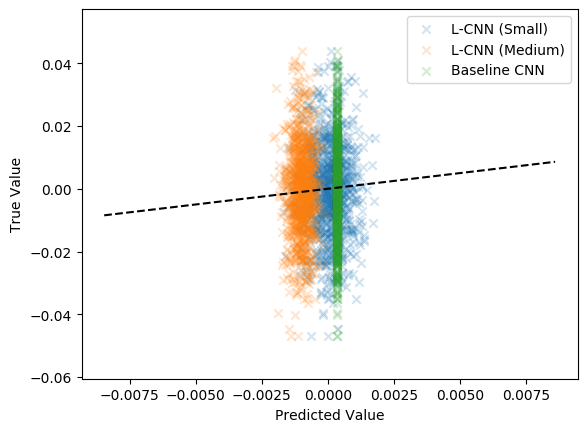

************
Trainable parameters
************
L-CNN (Small) 685
L-CNN (Medium) 11617
Baseline CNN 1329


In [49]:
run_tests(test_d2_w4x4_16, val_d2_w4x4_16, mode_out, model_paths, model_labels, model_baselines,
          dataset_paths, dataset_labels, dataset_labels_tex,
          batch_size=50)

# Wilson D2_1x3_m

In [50]:
# dataset base path
dataset_path = "../datasets/"

# specific test sets
dataset_paths = [
    dataset_path + "D2_8/test.hdf5",
    dataset_path + "D2_16/test.hdf5",
    dataset_path + "D2_32/test.hdf5",
    dataset_path + "D2_64/test.hdf5"
]

# plot labels for datasets
dataset_labels = [
    "8x8",
    "16x16",
    "32x32",
    "64x64",
]

# dataset labels for tex table
dataset_labels_tex = [
    "$8 \\cdot 8$",
    "$16 \\cdot 16$",
    "$32 \\cdot 32$",
    "$64 \\cdot 64$",
]

# model base path
model_path = "../scripts/"

# model results (lcnns)
model_paths = [
    model_path + "D2_W1x3_lcnn_m_results.pickle",
]

# add baseline model results
model_path_baseline = "../scripts_baseline/"
base_str = "D2_W1x3_baseline_{}_{}_results.pickle"
archs = ["S1"]
activations = ["relu"]

for a in archs:
    for act in activations:
        fp = model_path_baseline + base_str.format(a, act)
        model_paths.append(fp)

# model labels (used for plot labels and result files)
model_labels = [
    "D2_W1x3_lcnn_m",
]

# add baseline labels
archs = ["S1"]
activations = ["relu"]
for a in archs:
    for act in activations:
        label = "D2_W1x3_baseline_{}_{}".format(a, act)
        model_labels.append(label)

# whether a model is a baseline or not
model_baselines = [
    False,
]

for a in archs:
    for act in activations:
        model_baselines.append(True)
        
label_map = {
    "D2_W1x3_lcnn_m": "L-CNN ($W_{1\\times3}$)",
    "D2_W1x3_baseline_S1_relu": "Baseline CNN ($W_{1\\times3}$)"
}

model_labels = [label_map.get(label, label) for label in model_labels]
        
# output mode
mode_out = "trW_1x3"

# output path for pickled results
output_path = "D2_W1x3_results_large_m.pickle"
output_val_path = "D2_W1x3_val_results_large_m.pickle"
output_scatter_png = "d4_w1x3_scatter_large_m.pdf"

In [51]:
if RECOMPUTE_ALL:
    test_d2_w1x3_m = compute_test_results(mode_out, model_paths, model_labels, model_baselines,
                                        dataset_paths, dataset_labels, dataset_labels_tex,
                                        output_path, batch_size=1)

************
Test MSEs
************
0 L-CNN ($W_{1\times3}$) 8x8 [8 8] 4.251819e-07
0 L-CNN ($W_{1\times3}$) 16x16 [16 16] 1.2972852e-07
0 L-CNN ($W_{1\times3}$) 32x32 [32 32] 5.599878e-08
0 L-CNN ($W_{1\times3}$) 64x64 [64 64] 3.527043e-08
0 Baseline CNN ($W_{1\times3}$) 8x8 [8 8] 0.0014147613
1 Baseline CNN ($W_{1\times3}$) 8x8 [8 8] 0.0016042752
2 Baseline CNN ($W_{1\times3}$) 8x8 [8 8] 0.0016045694
3 Baseline CNN ($W_{1\times3}$) 8x8 [8 8] 0.0016030425
4 Baseline CNN ($W_{1\times3}$) 8x8 [8 8] 0.0013547485
0 Baseline CNN ($W_{1\times3}$) 16x16 [16 16] 0.0003888058
1 Baseline CNN ($W_{1\times3}$) 16x16 [16 16] 0.00046689916
2 Baseline CNN ($W_{1\times3}$) 16x16 [16 16] 0.00046679788
3 Baseline CNN ($W_{1\times3}$) 16x16 [16 16] 0.00046745138
4 Baseline CNN ($W_{1\times3}$) 16x16 [16 16] 0.0003590619
0 Baseline CNN ($W_{1\times3}$) 32x32 [32 32] 0.00011013998
1 Baseline CNN ($W_{1\times3}$) 32x32 [32 32] 0.000211362
2 Baseline CNN ($W_{1\times3}$) 32x32 [32 32] 0.00021151213
3 Baseli

In [52]:
if RECOMPUTE_ALL:
    val_d2_w1x3_m = compute_val_results(mode_out, model_paths, model_labels, model_baselines,
                                      output_val_path, batch_size=2)

************
Validation MSEs
************
0 L-CNN ($W_{1\times3}$) 4.119989e-07
0 Baseline CNN ($W_{1\times3}$) 0.0014951774
1 Baseline CNN ($W_{1\times3}$) 0.001696292
2 Baseline CNN ($W_{1\times3}$) 0.0016963168
3 Baseline CNN ($W_{1\times3}$) 0.0016962752
4 Baseline CNN ($W_{1\times3}$) 0.0014400587


In [53]:
if not RECOMPUTE_ALL:
    test_d2_w1x3_m = pickle.load(open(output_path, "rb"))
    val_d2_w1x3_m = pickle.load(open(output_val_path, "rb"))

************
MSE plots
************


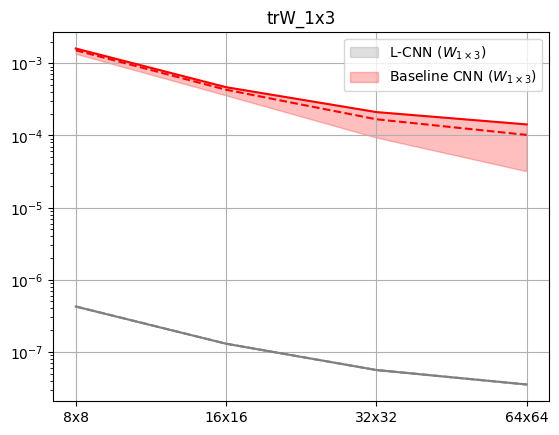

************
Best models of each ensemble according to val_loss
************
************
Scatter plot
************
Test MSE (L-CNN ($W_{1\times3}$)): 4.2519e-07
Test MSE (Baseline CNN ($W_{1\times3}$)): 1.3547e-03


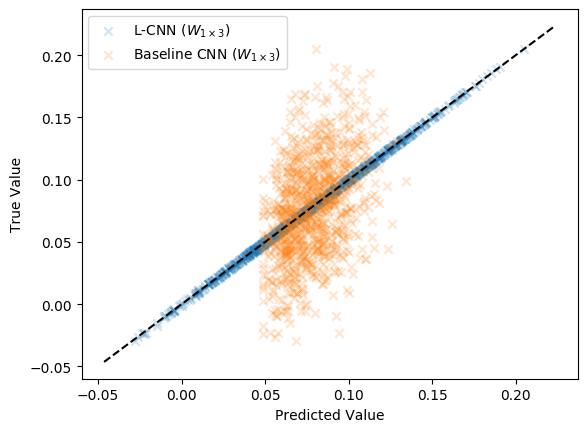

************
Trainable parameters
************
L-CNN ($W_{1\times3}$) 525
Baseline CNN ($W_{1\times3}$) 1249


In [54]:
run_tests(test_d2_w1x3_m, val_d2_w1x3_m, mode_out, model_paths, model_labels, model_baselines,
          dataset_paths, dataset_labels, dataset_labels_tex,
          batch_size=50)

# Wilson D2_2x3_m

In [55]:
# dataset base path
dataset_path = "../datasets/"

# specific test sets
dataset_paths = [
    dataset_path + "D2_8/test.hdf5",
    dataset_path + "D2_16/test.hdf5",
    dataset_path + "D2_32/test.hdf5",
    dataset_path + "D2_64/test.hdf5"
]

# plot labels for datasets
dataset_labels = [
    "8x8",
    "16x16",
    "32x32",
    "64x64",
]

# dataset labels for tex table
dataset_labels_tex = [
    "$8 \\cdot 8$",
    "$16 \\cdot 16$",
    "$32 \\cdot 32$",
    "$64 \\cdot 64$",
]

# model base path
model_path = "../scripts/"

# model results (lcnns)
model_paths = [
    model_path + "D2_W2x3_lcnn_m_results.pickle",
]

# add baseline model results
model_path_baseline = "../scripts_baseline/"
base_str = "D2_W2x3_baseline_{}_{}_results.pickle"
archs = ["S1"]
activations = ["relu"]

for a in archs:
    for act in activations:
        fp = model_path_baseline + base_str.format(a, act)
        model_paths.append(fp)

# model labels (used for plot labels and result files)
model_labels = [
    "D2_W2x3_lcnn_m",
]

# add baseline labels
archs = ["S1"]
activations = ["relu"]
for a in archs:
    for act in activations:
        label = "D2_W2x3_baseline_{}_{}".format(a, act)
        model_labels.append(label)

# whether a model is a baseline or not
model_baselines = [
    False,
]

for a in archs:
    for act in activations:
        model_baselines.append(True)
        
label_map = {
    "D2_W2x3_lcnn_m": "L-CNN ($W_{2\\times3}$)",
    "D2_W2x3_baseline_S1_relu": "Baseline CNN ($W_{2\\times3}$)"
}

model_labels = [label_map.get(label, label) for label in model_labels]
        
# output mode
mode_out = "trW_2x3"

# output path for pickled results
output_path = "D2_W2x3_results_large_m.pickle"
output_val_path = "D2_W2x3_val_results_large_m.pickle"
output_scatter_png = "d4_w2x3_scatter_large_m.pdf"

In [56]:
if RECOMPUTE_ALL:
    test_d2_w2x3_m = compute_test_results(mode_out, model_paths, model_labels, model_baselines,
                                        dataset_paths, dataset_labels, dataset_labels_tex,
                                        output_path, batch_size=1)

************
Test MSEs
************
0 L-CNN ($W_{2\times3}$) 8x8 [8 8] 1.2909979e-05
0 L-CNN ($W_{2\times3}$) 16x16 [16 16] 3.037096e-06
0 L-CNN ($W_{2\times3}$) 32x32 [32 32] 9.567851e-07
0 L-CNN ($W_{2\times3}$) 64x64 [64 64] 3.396353e-07
0 Baseline CNN ($W_{2\times3}$) 8x8 [8 8] 0.0009702487
1 Baseline CNN ($W_{2\times3}$) 8x8 [8 8] 0.000970952
2 Baseline CNN ($W_{2\times3}$) 8x8 [8 8] 0.000975307
3 Baseline CNN ($W_{2\times3}$) 8x8 [8 8] 0.00097056496
4 Baseline CNN ($W_{2\times3}$) 8x8 [8 8] 0.00097046135
0 Baseline CNN ($W_{2\times3}$) 16x16 [16 16] 0.00023855556
1 Baseline CNN ($W_{2\times3}$) 16x16 [16 16] 0.00024105227
2 Baseline CNN ($W_{2\times3}$) 16x16 [16 16] 0.00024574215
3 Baseline CNN ($W_{2\times3}$) 16x16 [16 16] 0.00024001286
4 Baseline CNN ($W_{2\times3}$) 16x16 [16 16] 0.00024064614
0 Baseline CNN ($W_{2\times3}$) 32x32 [32 32] 6.302633e-05
1 Baseline CNN ($W_{2\times3}$) 32x32 [32 32] 6.438765e-05
2 Baseline CNN ($W_{2\times3}$) 32x32 [32 32] 6.639423e-05
3 Basel

In [57]:
if RECOMPUTE_ALL:
    val_d2_w2x3_m = compute_val_results(mode_out, model_paths, model_labels, model_baselines,
                                      output_val_path, batch_size=2)

************
Validation MSEs
************
0 L-CNN ($W_{2\times3}$) 1.2073035e-05
0 Baseline CNN ($W_{2\times3}$) 0.0009591907
1 Baseline CNN ($W_{2\times3}$) 0.0009590628
2 Baseline CNN ($W_{2\times3}$) 0.00096472143
3 Baseline CNN ($W_{2\times3}$) 0.0009589782
4 Baseline CNN ($W_{2\times3}$) 0.0009589771


In [58]:
if not RECOMPUTE_ALL:
    test_d2_w2x3_m = pickle.load(open(output_path, "rb"))
    val_d2_w2x3_m = pickle.load(open(output_val_path, "rb"))

************
MSE plots
************


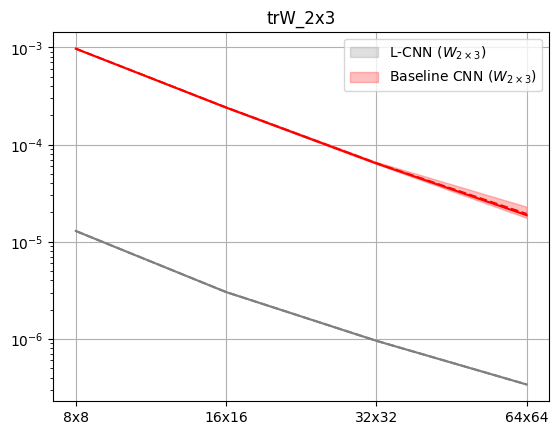

************
Best models of each ensemble according to val_loss
************
************
Scatter plot
************
Test MSE (L-CNN ($W_{2\times3}$)): 1.2910e-05
Test MSE (Baseline CNN ($W_{2\times3}$)): 9.7046e-04


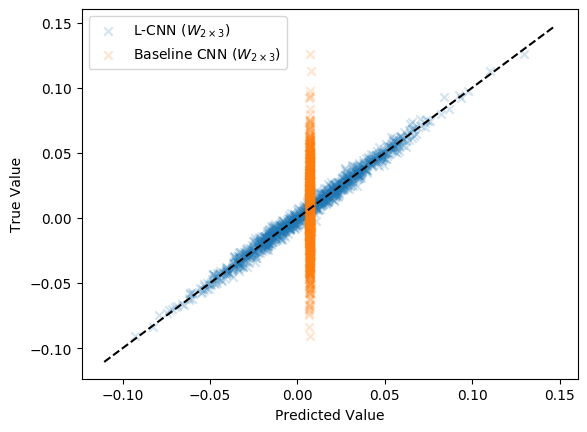

************
Trainable parameters
************
L-CNN ($W_{2\times3}$) 525
Baseline CNN ($W_{2\times3}$) 1317


In [59]:
run_tests(test_d2_w2x3_m, val_d2_w2x3_m, mode_out, model_paths, model_labels, model_baselines,
          dataset_paths, dataset_labels, dataset_labels_tex,
          batch_size=50)